In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
description = open("/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt")
print(description.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [3]:
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**First thoughts.  This is a lot of data.  Much of it is catagorical.  Random-Forest might pull something from those pieces.**

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Prices Vs. Time

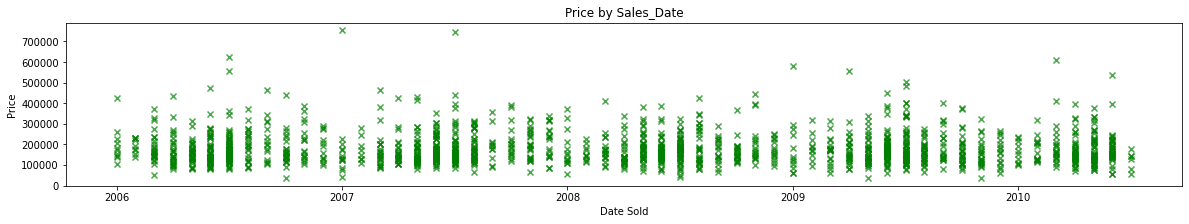

In [5]:
price = train_data['SalePrice']
year_sold = train_data['YrSold']
month_sold = train_data['MoSold']
date_sold = list()
i = 0
while i < len(year_sold):
    date = year_sold[i] + (month_sold[i] - 1) / 12
    date_sold.append(date)
    i += 1

plt.figure(figsize=(20,3))
plt.title('Price by Sales_Date')
plt.xlabel('Date Sold')
plt.ylabel('Price')
plt.scatter(date_sold, price, marker='x', color='g', alpha=.7)
plt.show()

Sales only go back 5 years.  I can run a linear regresion, but prices look relatively stable over this time frame.  Heavier sales in the summer.  Usually higher demand increases sales price, but it is hard to see in this graph.  Maybe, slightly sinusoidal.  I could create a feature that was average sales price in a given month.

# Price Vs. Square Footage

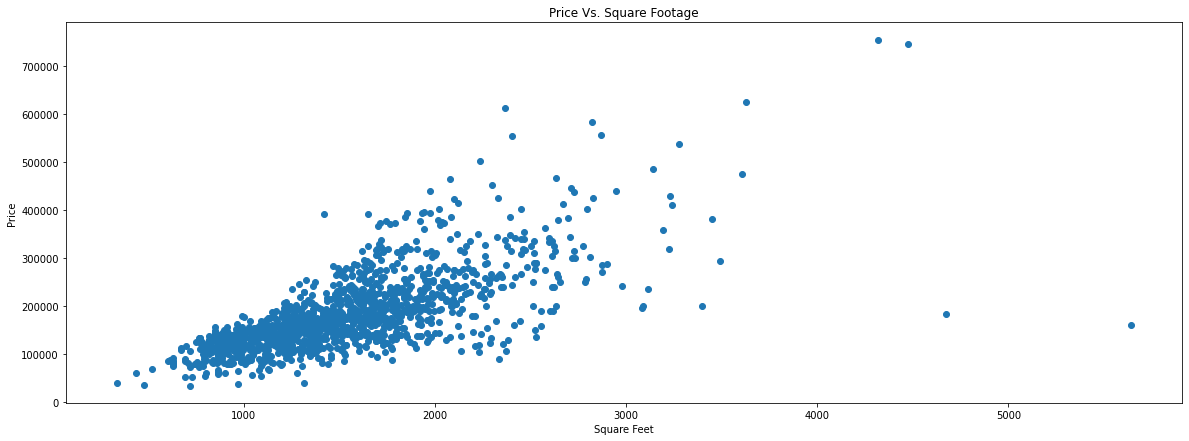

In [6]:
plt.figure(figsize=(20,7))
plt.title('Price Vs. Square Footage')
plt.xlabel('Square Feet')
plt.ylabel('Price')
plt.scatter(train_data['GrLivArea'], price, marker='o')
plt.show()

Ok, this seems like a good candidate for linear regression.

# Price Vs. Year Built

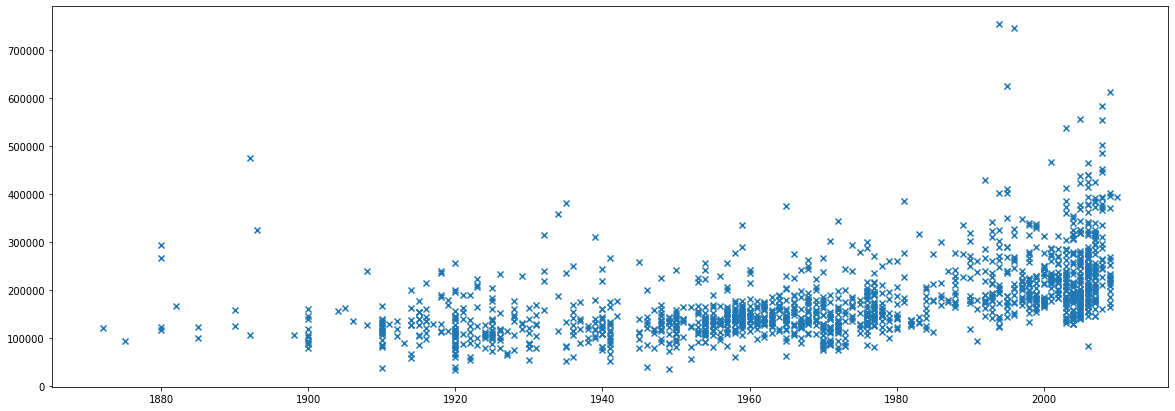

In [7]:
plt.figure(figsize=(20,7))
plt.scatter(train_data['YearBuilt'], price, marker='x')
plt.show()

**Possible quadratic regression**

# Average Price per Neighborhood

In [8]:
neighborhoods = list(train_data['Neighborhood'])
prices = list(train_data['SalePrice'])
prices_per_neighborhood = dict()
i = 0
while i < len(neighborhoods):
    neighborhood = neighborhoods[i]
    price = prices[i]
    if neighborhood in prices_per_neighborhood:
        data = prices_per_neighborhood[neighborhood]
        data.append(price)
        prices_per_neighborhood[neighborhood] = data
    else:
        prices_per_neighborhood[neighborhood] = [price]
    i += 1
average_per_neighborhood = dict()
for key in prices_per_neighborhood.keys():
    data = prices_per_neighborhood[key]
    average = round((sum(data) / len(data)), 2)
    average_per_neighborhood[key] = average
average_list = list()
for key in average_per_neighborhood.keys():
    average_list.append([average_per_neighborhood[key], key])
average_list.sort()        

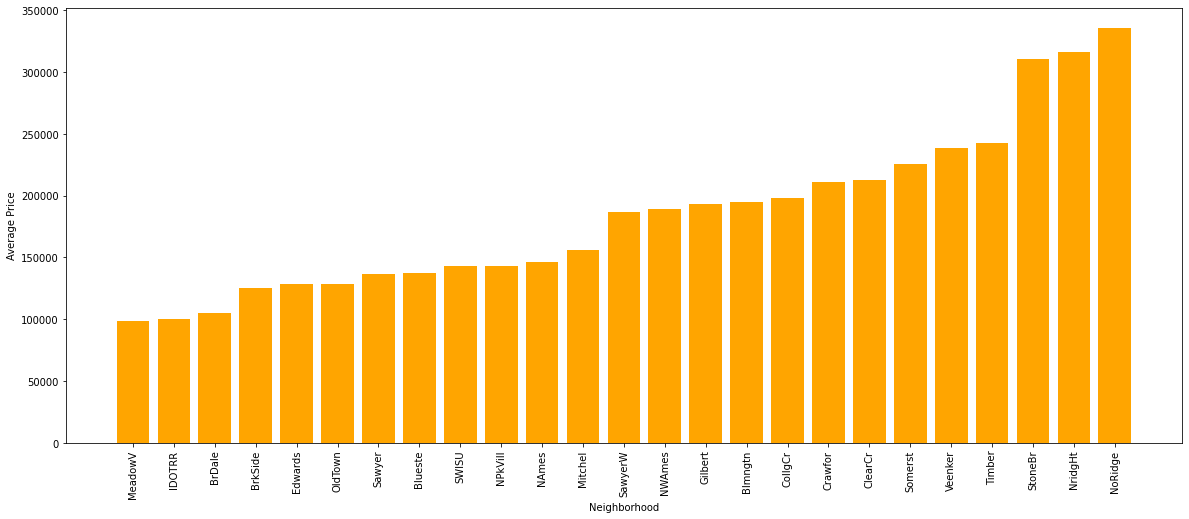

In [9]:
neighborhoods = list()
average_price = list()
for entry in average_list:
    neighborhoods.append(entry[1])
    average_price.append(entry[0])

plt.figure(figsize=(20,8))
plt.ylabel('Average Price')
plt.xlabel('Neighborhood')
plt.bar(range(len(neighborhoods)), average_price, color='orange')
plt.xticks(range(len(neighborhoods)), neighborhoods, rotation='vertical')
plt.show()

**Clearly, neighboorhood is an important factor.  Some neighboorhoods may have too little data though.  They may very well be coorilated to the age of the building as well.**